# Single-point, semi-honest case

In this scenario, Alice and Bob are both assumed to be semi-honest, meaning that they will follow the protocol as specified, but they may try to learn more about the other party's input by analyzing the messages they receive. The goal is to compute the valuation of Bob's data point $x$, defined as the negative loss of the datapoint on Alice's model $M$.


## Part 0: The setup


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


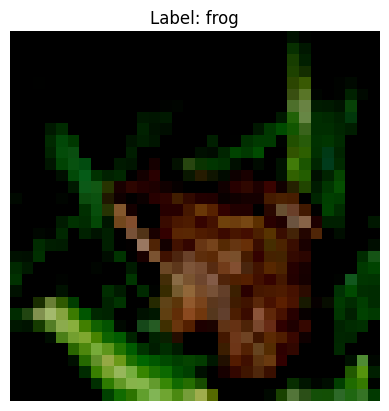

In [1]:
#First, we define Alice's model M. We assume a simple CNN model.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt

class LeNet(nn.Sequential):
    """
    Adaptation of LeNet that uses ReLU activations
    """

    # network architecture:
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = LeNet()
#Save the model weights
torch.save(model.state_dict(), 'data/model.pth')

#Next, we define the data loader for CIFAR-10 dataset.
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=False,transform=transform)
data, lbl  = trainset[4]
classes = trainset.classes  # ['airplane', 'automobile', 'bird', ..., 'truck']
class_name = classes[lbl]

label_eye = torch.eye(10)
label = label_eye[lbl]

torch.save(data, 'data/data.pth')
torch.save(label, 'data/lbl.pth')

# Since 'image' is a Torch tensor of shape (C, H, W),
# we need to permute the axes to (H, W, C) for display.
plt.imshow(data.permute(1, 2, 0))

# Add the class name as the title
plt.title(f"Label: {class_name}")
plt.axis('off')  # Hide axis ticks
plt.show()

#The variable model is Alice's model M, the variable data and lbl is Bob's contribution (x,y).

## Part 1: Model Inference

Given that both parties are semi-honest, we can utilize the library CrypTen. CrypTen is an SMPC library that operates under semi-honest assumptions. 

In [6]:
import crypten
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

crypten.init()
crypten.common.serial.register_safe_class(LeNet)

#Define the rank of Alice and Bob
ALICE = 0
BOB = 1

#Encrypt model
model = LeNet() #Reload model 
model.load_state_dict(torch.load('./data/model.pth')) #Alice loads model weights
dummy_input = torch.empty(data.shape).unsqueeze_(0)
encrypted_model = crypten.nn.from_pytorch(model, dummy_input)
encrypted_model.encrypt(src=ALICE)
print("Model successfully encrypted:", encrypted_model.encrypted)



Model successfully encrypted: True


/home/thomas/miniconda3/envs/secdataval/lib/python3.7/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [8]:
import crypten.mpc as mpc
import crypten.communicator as comm



@mpc.run_multiprocess(world_size=2)
def run_encrypted_valuation():
    #Load pretrained model to Alice
    model = crypten.load_from_party('data/model.pth', src=ALICE)
    # #Encrypt model from Alice 
    # dummy_input = torch.empty(data.shape).unsqueeze_(0)
    # encrypted_model = crypten.nn.from_pytorch(model, dummy_input)
    # encrypted_model.encrypt(src=ALICE)

    # #Load data to Bob
    # data = crypten.load_from_party('data/data.pth', src=BOB)
    # label = crypten.load_from_party('data/lbl.pth', src=BOB)

run_encrypted_valuation()

Process Process-9:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/site-packages/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/home/thomas/miniconda3/envs/secdataval/lib/python3.7/site-packages/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_ar